## Time Series Forecasting

**Problem Statement:**
As a Data Scientist at Kalbe Nutritionals, you have been tasked by the inventory teams to assist in predicting the sales quantity of the entire range of Kalbe products.

**Objective:**
The goal of this project is to develop a forecasting model that can predict the daily sales quantity of Kalbe products. This model will be utilized to generate estimates of the quantity of products that will be sold in the future.

### 1. Load Dataset

In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.7 MB/s eta 0:00:00


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
import numpy as np

In [3]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

# Or, only disable specific warnings based on category
# Example: Disabling DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
folder_path = '/content/drive/MyDrive/rakamin/kalbe/'

In [6]:
df = pd.read_csv(folder_path+'df_merged.csv')

In [7]:
df.head()

,TransactionID,CustomerID,Age,Gender,Marital Status,Income,Date,ProductID,Product Name,Price_x,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,TR10008,235,37,0,Married,"5,35",2022-05-21,P8,Oat,16000,2,32000,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664
1,TR32057,235,37,0,Married,"5,35",2022-06-10,P7,Coffee Candy,9400,3,28200,7,Buana Indah,Buana,General Trade,3.316694,114.590111
2,TR47938,235,37,0,Married,"5,35",2022-10-18,P3,Crackers,7500,4,30000,7,Buana Indah,Buana,General Trade,3.316694,114.590111
3,TR49065,235,37,0,Married,"5,35",2022-10-08,P5,Thai Tea,4200,4,16800,7,Buana Indah,Buana,General Trade,3.316694,114.590111
4,TR50919,235,37,0,Married,"5,35",2022-08-18,P7,Coffee Candy,9400,4,37600,7,Buana Indah,Buana,General Trade,3.316694,114.590111


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TransactionID   4908 non-null   object 
 1   CustomerID      4908 non-null   int64  
 2   Age             4908 non-null   int64  
 3   Gender          4908 non-null   int64  
 4   Marital Status  4908 non-null   object 
 5   Income          4908 non-null   object 
 6   Date            4908 non-null   object 
 7   ProductID       4908 non-null   object 
 8   Product Name    4908 non-null   object 
 9   Price_x         4908 non-null   int64  
 10  Qty             4908 non-null   int64  
 11  TotalAmount     4908 non-null   int64  
 12  StoreID         4908 non-null   int64  
 13  StoreName       4908 non-null   object 
 14  GroupStore      4908 non-null   object 
 15  Type            4908 non-null   object 
 16  Latitude        4908 non-null   float64
 17  Longitude       4908 non-null   f

In [9]:
# Convert the "Date" column to datetime data type with the specified format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

### 2. Calculate Total Quantity per day

In [10]:
df_totalquantity = df.groupby('Date')["Qty"].sum().reset_index()

In [11]:
df_totalquantity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    365 non-null    datetime64[ns]
 1   Qty     365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [12]:
df_totalquantity.set_index('Date', inplace=True)

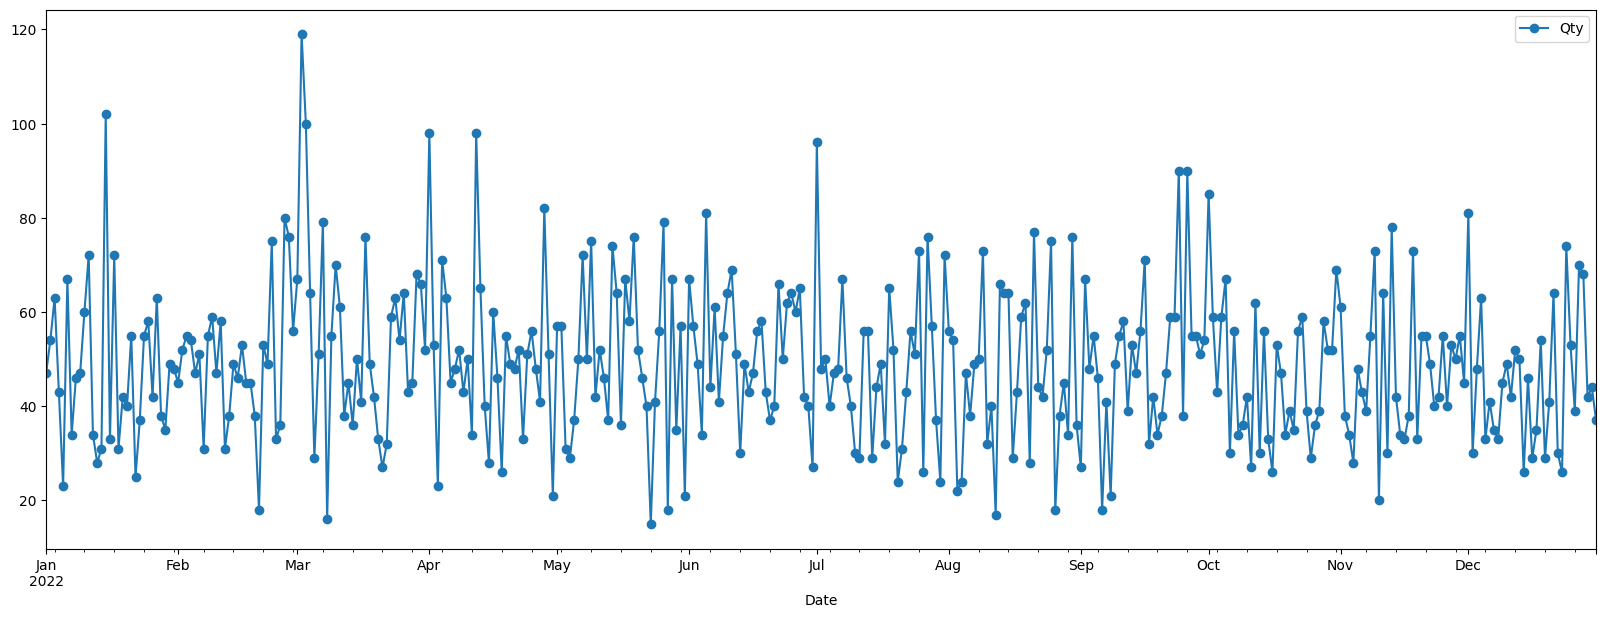

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 7
df_totalquantity.plot(marker='o')
plt.show()

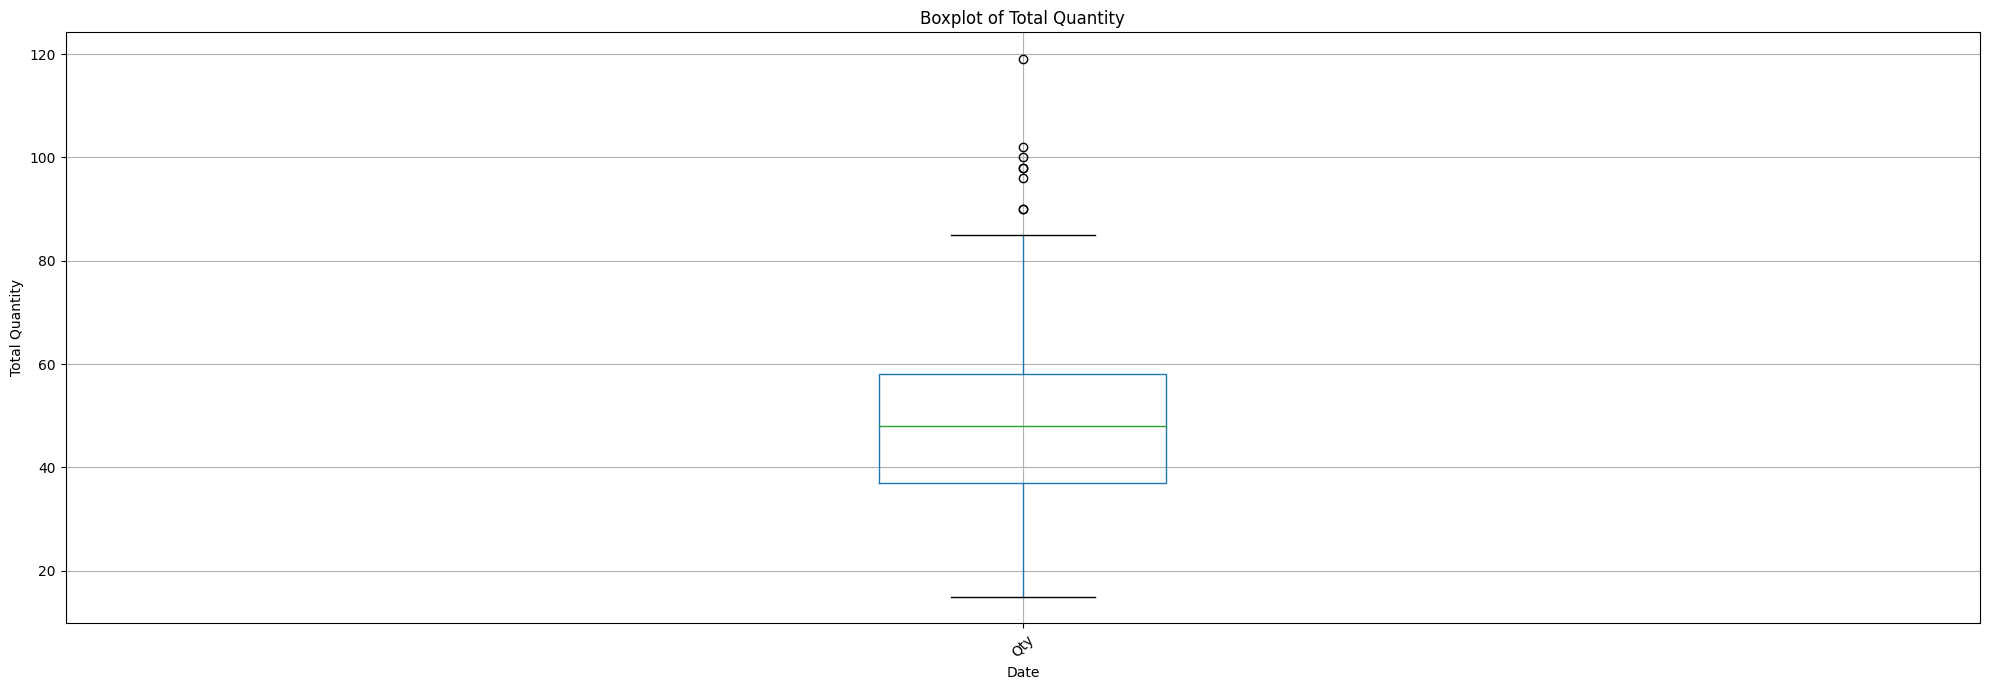

In [14]:
# Assuming df_totalquantity is your DataFrame with 'Date' as the index
df_totalquantity.boxplot()
plt.title('Boxplot of Total Quantity')
plt.ylabel('Total Quantity')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3. Stationary Test

H0: It is non-stationary

H1: It is stationary

p-value <= 0.05 so H0 rejected.

p-value >0.05 so H0 accepted.

In [17]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [18]:
adfuller_test(df_totalquantity['Qty'])

ADF Test Statistic : -19.42597456986564
p-value : 0.0
#Lags Used : 0
Number of Observations : 364
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


data is already stationary.

Now looking the p, d and q value for ARIMA

### 4. Chose best p, d and q

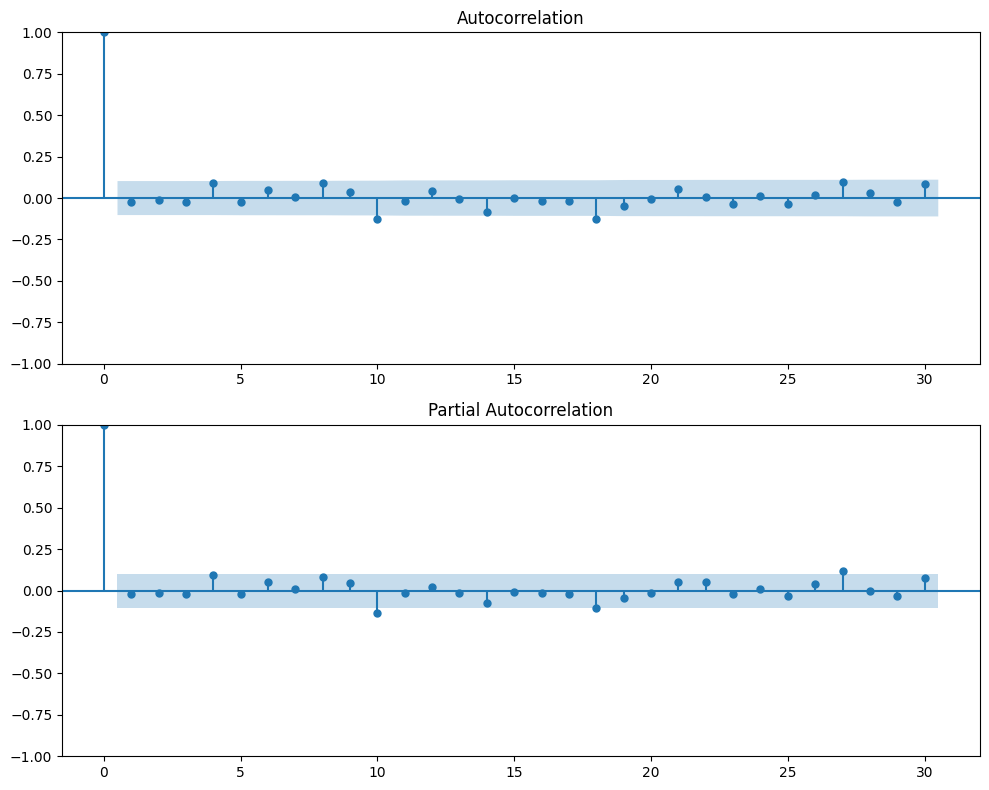

In [22]:
# Create ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_totalquantity['Qty'], lags=30, ax=ax1)
plot_pacf(df_totalquantity['Qty'], lags=30, ax=ax2)

plt.tight_layout()
plt.show()

p = 4
q = 4
d = 0

In [26]:
aic_scores = []
# Fit the ARIMA model
model = ARIMA(df_totalquantity['Qty'], order=(4,0,4))
model_fit = model.fit()
# Add AIC score to the list
aic_scores.append({'par': '(4,0,4)', 'aic': model_fit.aic})

In [27]:
aic_scores

[{'par': '(4,0,4)', 'aic': 3088.385954972111}]

#### grid search hyperparameter tuning

In [33]:
from itertools import product

# Define ranges for p, d, and q
p = range(0, 5)  # 0 to 7
d = range(0, 3)  # 0 to 2
q = range(0, 5)  # 0 to 7

# Use the product function from itertools
# to create combinations of p, d, and q
pdq = list(product(p, d, q))
print(pdq)


[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 2, 4), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 0, 3), (4, 0, 4), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4), (4, 2, 0), (4, 2, 1), (4, 2, 2), (4, 2, 3), (4, 2, 4)]


Manual grid search to find the optimal combination of parameters (p, d, q) for an ARIMA model based on the lowest AIC score.

In [34]:
# Splitting data into training and testing with ratio 8 : 2
data_train = df_totalquantity[:292]["Qty"]
data_test = df_totalquantity[292:]['Qty']

# Creating a list to store AIC scores
aic_scores = []

# Performing manual grid search to find optimal p, d, q
for param in pdq:
    # Fitting the ARIMA model
    model = ARIMA(data_train, order=param)
    model_fit = model.fit()
    # Adding AIC score to the list
    aic_scores.append({'par': param, 'aic': model_fit.aic})

# Finding the smallest AIC score
best_aic = min(aic_scores, key=lambda x: x['aic'])

print(best_aic)

# Creating an ARIMA model with the best p, d, and q from grid search
model = ARIMA(data_train, order=(best_aic['par']))
model_fit = model.fit()

# Making predictions for the next 73 days (testing data)
preds = model_fit.forecast(73)


{'par': (2, 1, 3), 'aic': 2476.234790599905}


<Axes: >

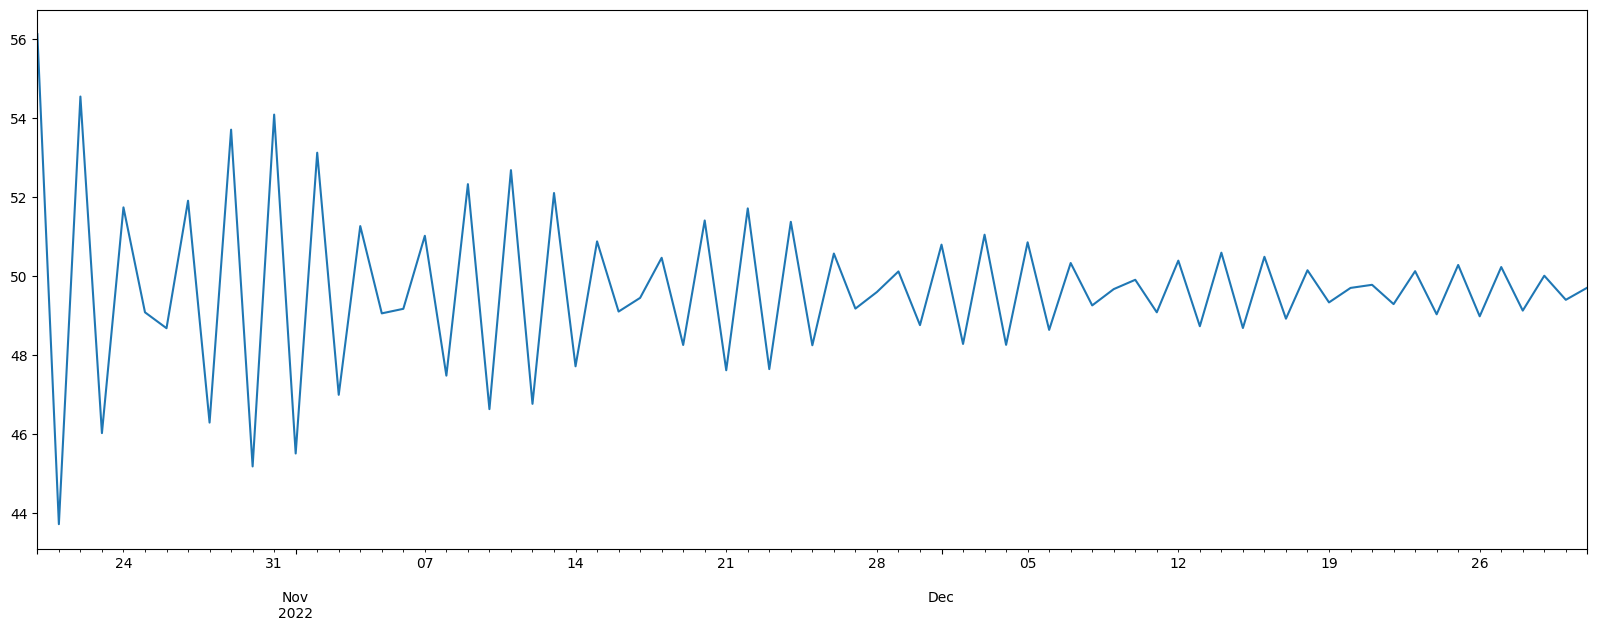

In [35]:
preds.plot()

#### auto arima
Choose p, d and q automatic

In [36]:
import pmdarima as pm

auto_arima = pm.auto_arima(data_train,stepwise=False, seasonal=False)
forecast = auto_arima.predict(n_periods=73)

auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1285.661
Date:                Tue, 29 Aug 2023   AIC                           2579.321
Time:                        04:02:59   BIC                           2594.028
Sample:                    01-01-2022   HQIC                          2585.212
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3361      0.057      5.845      0.000       0.223       0.449
ar.L2          0.3237      0.060      5.351      0.000       0.205       0.442
ar.L3          0.3004      0.054      5.526      0.000       0.194       0.407
sigma2       387.5657     29.419     13.174      0.000     329.906     445.225
===================================================================================
Ljung-Box (L1) (Q):                   3.91   Jarque-Bera (JB):                 3.16
Prob(Q):                              0.05   Prob(JB):                         0.21
Heteroskedasticity (H):               0.85   Skew:                             0.19
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

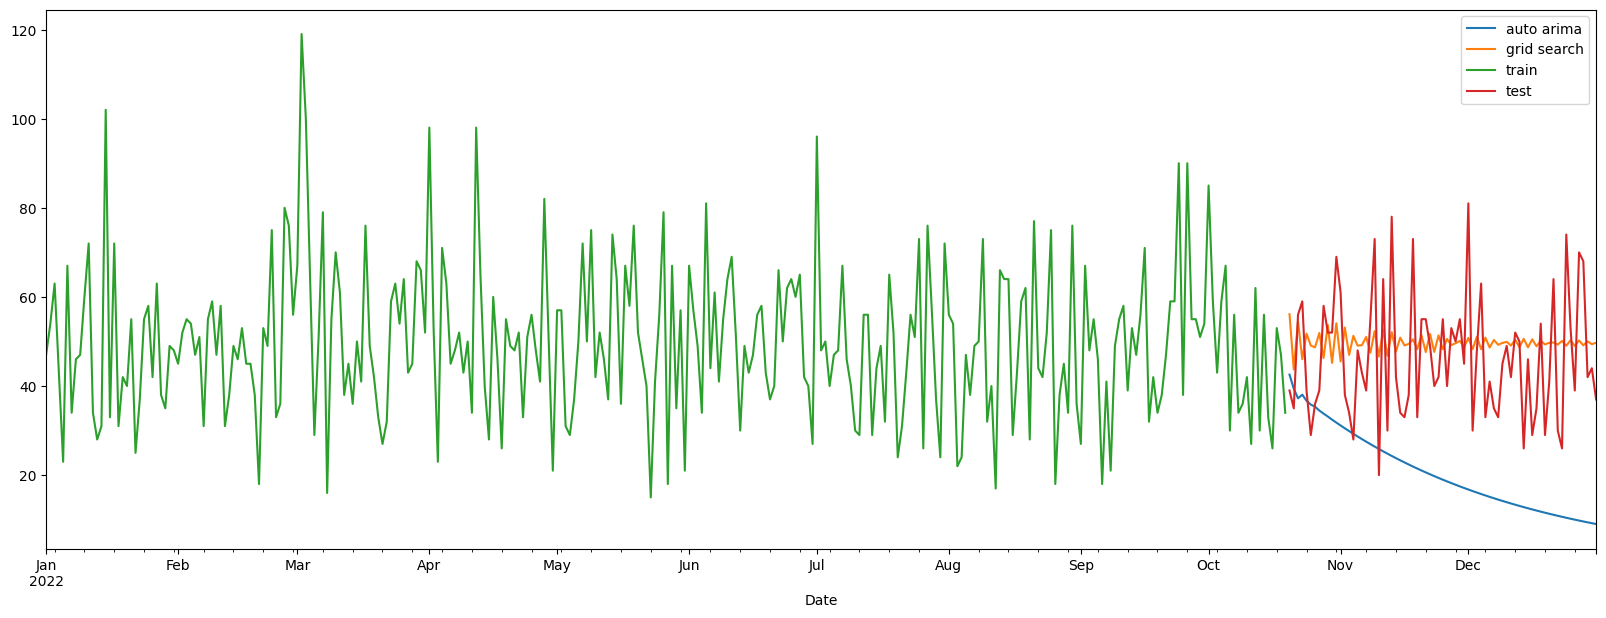

In [37]:
# ploting
forecast.plot(label='auto arima')
preds.plot(label='grid search')

data_train.plot(label='train')
data_test.plot(label='test')
plt.legend()

While both methods, Auto ARIMA and grid search, are useful in selecting optimal parameters for the ARIMA model, in this case, the use of **grid search seems more appropriate.**

### 5. evaluate model


In [40]:
# Calculate RMSE for training data
train_predictions = model_fit.predict(start=data_train.index[0], end=data_train.index[-1])
train_rmse = np.sqrt(mean_squared_error(data_train, train_predictions))

# Calculate RMSE for testing data
test_rmse = np.sqrt(mean_squared_error(data_test, preds))

print(f"RMSE for Training Data: {train_rmse:.2f}")
print(f"RMSE for Testing Data: {test_rmse:.2f}")

RMSE for Training Data: 16.89
RMSE for Testing Data: 14.07


<Axes: xlabel='Date'>

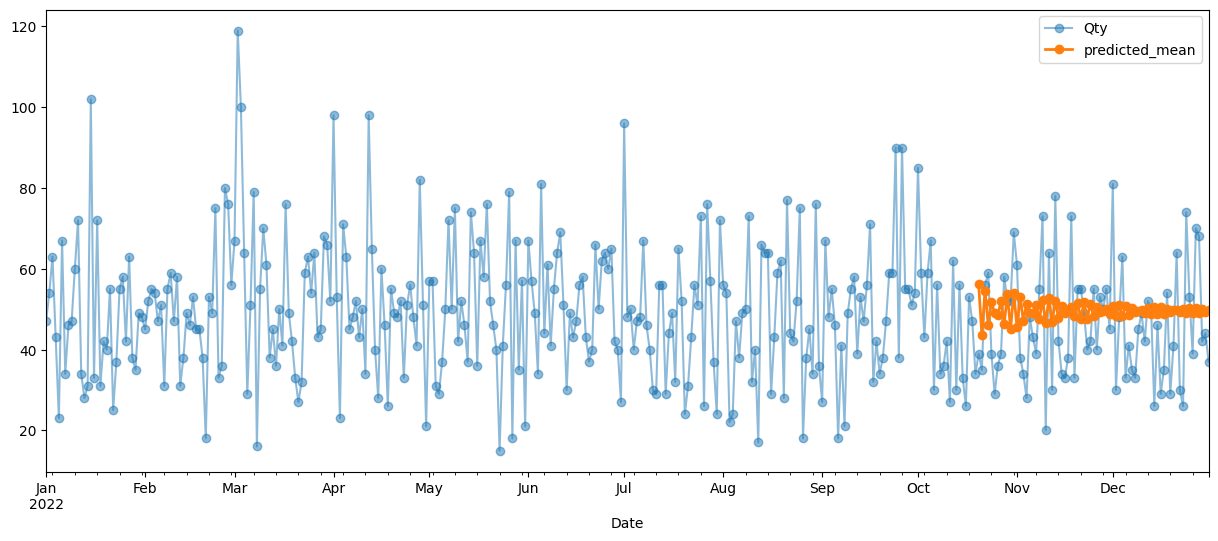

In [41]:
df_totalquantity.plot(figsize=(15, 6), alpha=0.5, marker="o")
preds.plot(linewidth=2, marker="o", legend=True)

The parameter values p = 2, d = 1, and q = 3 resulted in an RMSE value of 14.07 dan RMSE for Training Data is 16.89.

The difference between the RMSE values for training (16.89) and testing (14.07) is not too large suggests that the model is not overfitting. A smaller difference indicates that the model is generalizing reasonably well to unseen data.


### 6. forecasting 30 days using p = 2, d = 1 and q=3

<Axes: >

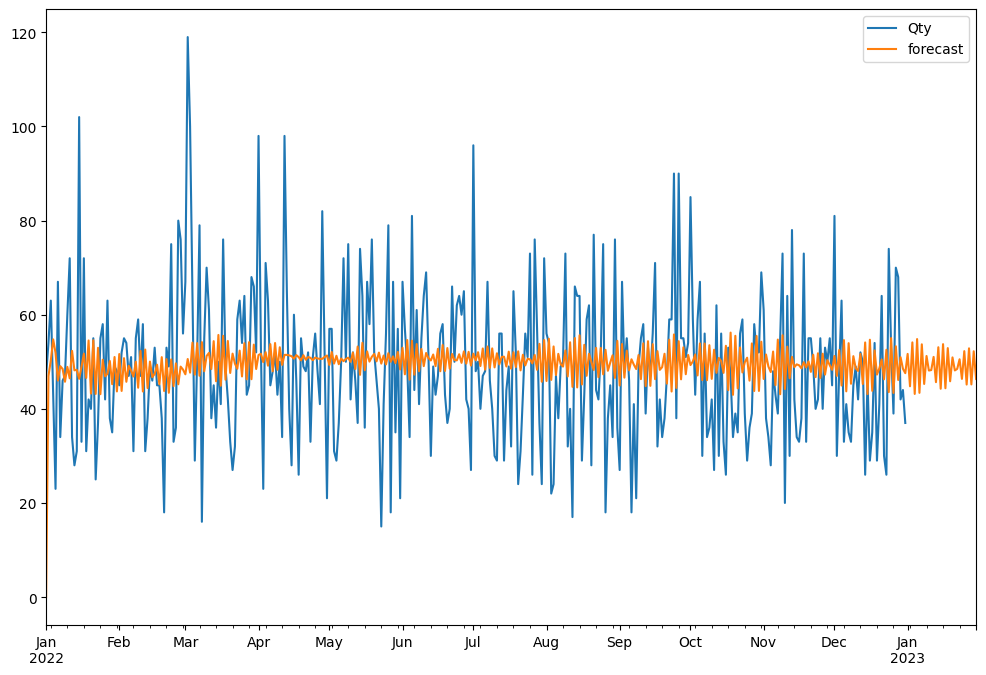

In [42]:
from pandas.tseries.offsets import DateOffset

future_dates=[df_totalquantity.index[-1]+ DateOffset(days=x)for x in range(0,31)]
future_dates_df=pd.DataFrame(index=future_dates[1:],columns=df_totalquantity.columns)

future_df = pd.concat([df_totalquantity,future_dates_df])

model=ARIMA(df_totalquantity['Qty'], order=(2,1,3))
model_fit=model.fit()

future_df['forecast'] = model_fit.predict(start = 0, end = 395, dynamic = False)
future_df[['Qty', 'forecast']].plot(figsize=(12, 8))

In [44]:
future_df.tail(30).mean()

Qty               NaN
forecast    48.936303
dtype: float64

### 7. Saving Model

In [45]:
import pickle

# Creating an ARIMA model with the best p, d, and q from grid search
model = ARIMA(df_totalquantity['Qty'], order=best_aic['par'])
model_fit = model.fit()

# Save the model to a file using pickle
model_filename = 'arima_model.pkl'
with open(folder_path+model_filename, 'wb') as model_file:
    pickle.dump(model_fit, model_file)

print("Model saved successfully!")

Model saved successfully!


In [46]:
import pickle
# Load the ARIMA model from the file
model_filename = 'arima_model.pkl'
with open(folder_path + model_filename, 'rb') as model_file:
    loaded_model_fit = pickle.load(model_file)

# Number of days for prediction
num_days = 30

# Forecast the next 30 days
forecast = loaded_model_fit.forecast(steps=num_days)

print("Forecasted quantities for the next", num_days, "days:")
print(forecast)


Forecasted quantities for the next 30 days:
2023-01-01    51.673651
2023-01-02    44.795771
2023-01-03    54.120410
2023-01-04    43.168776
2023-01-05    54.829755
2023-01-06    43.399467
2023-01-07    53.711159
2023-01-08    45.286103
2023-01-09    51.232232
2023-01-10    48.141497
2023-01-11    48.237900
2023-01-12    51.034947
2023-01-13    45.668555
2023-01-14    53.090458
2023-01-15    44.269443
2023-01-16    53.747237
2023-01-17    44.379613
2023-01-18    52.906534
2023-01-19    45.858474
2023-01-20    50.928585
2023-01-21    48.162342
2023-01-22    48.491248
2023-01-23    50.537201
2023-01-24    46.362821
2023-01-25    52.261229
2023-01-26    45.163728
2023-01-27    52.860375
2023-01-28    45.189782
2023-01-29    52.233806
2023-01-30    46.345988
Freq: D, Name: predicted_mean, dtype: float64


<Axes: >

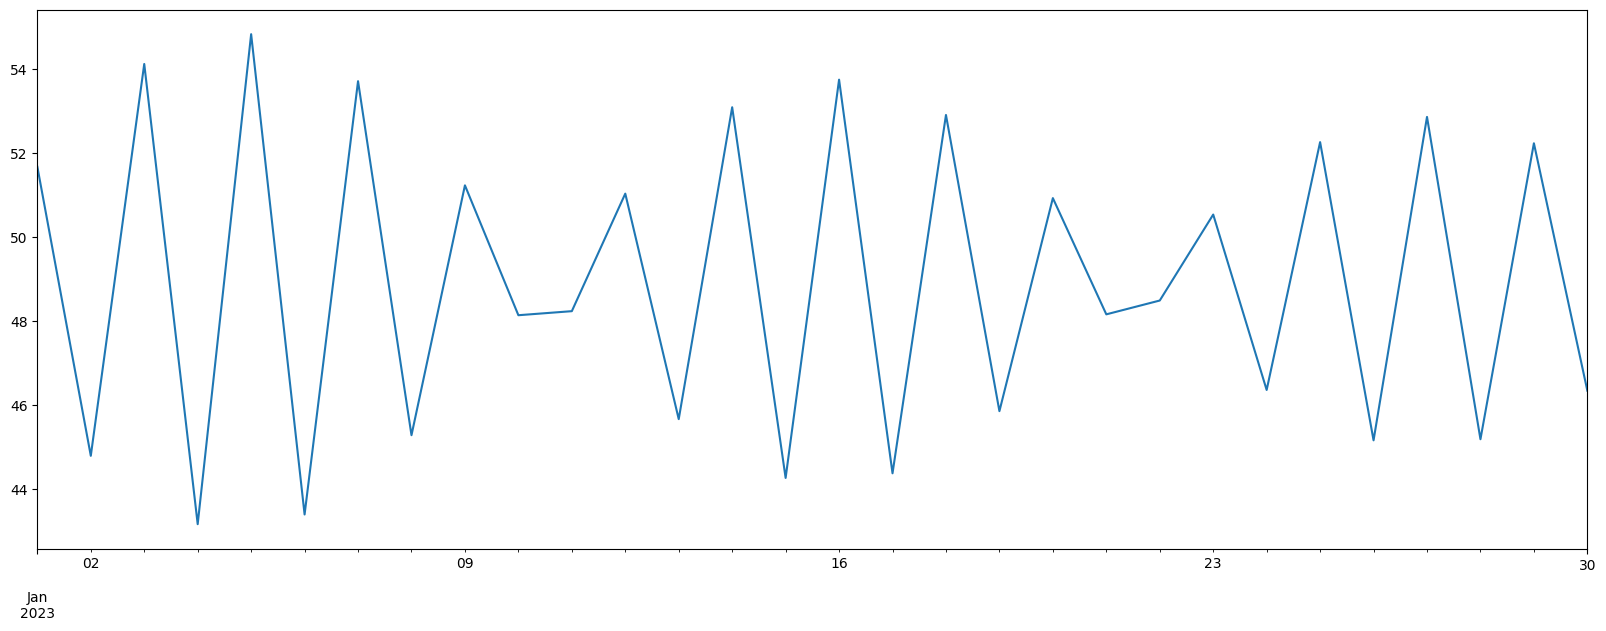

In [47]:
forecast.plot()

### Conclusion
1. The ARIMA parameters, namely p, d, and q, are set to 2, 1, and 3, respectively.
2. The RMSE values for the training and testing datasets are 17.41 and 13.47, respectively.
3. No Overfitting Detected: The model is not exhibiting overfitting.
4. Exploring Alternative Time Series Algorithms: Let's try utilizing different time series algorithms.